# Poisson process filtering - Deep Learning approach

## Problem and notations

Let $N_a$ and $N_b$ be 2 independant [Poisson point processes](https://en.wikipedia.org/wiki/Poisson_point_process) of respective intensities $a > 0$ and $b > 0$.

Let $\tau \sim \mathcal{E}(\mu)$ independant of $N_a$ and $N_b$, where $\mu > 0$.

Let $N$ be the "concatenated" process of the of $N_a$ before $\tau$, and $N_b$ after $\tau$:

$$\forall t \ge 0, \, N(t) = \mathcal{1}_{\tau < t} \, N_a(t) + \mathcal{1}_{\tau > t} \, N_b(t)$$

## Imports

In [103]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("hls")
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [2]:
tf.config.list_physical_devices()

2022-08-02 18:09:53.667909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 18:09:53.667964: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 18:09:53.668006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deepthought): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Process generating

In [3]:
# Poisson model parameters
a = 5    # 1st intensity
b = 10   # 2nd intensity
beg = 0  # beginning of times
end = 10 # end of times
mu = 0.2 # parameter of the exponential distribution

In [4]:
print(f"The expected value of tau is {1/mu:.1f}")

The expected value of tau is 5.0


In [5]:
def poisson_proc(lmbda, orig, horiz, rng):
    """
    Generates arrivals of a point Poisson process
    """
    arrivals = []
    t = orig
    while t < horiz:
        t = t - np.log(rng.random()) / lmbda
        arrivals.append(t)
    
    return np.sort(arrivals[:-1])   

In [6]:
MAX_ARRIVALS = 128 

In [46]:
def trajectory(a, b, mu, beg, end, rng):
    """
    Generates concatenated processes arrivals
    """
    tau = beg + rng.exponential(1/mu)
    while tau > end: # force sampling of tau in (beg, end)
        tau = beg + rng.exponential(1/mu)
    arrivals = np.concatenate((poisson_proc(a, beg, tau, rng),
                               poisson_proc(b, tau, end, rng)))
    arrivals = arrivals[:MAX_ARRIVALS]                                        # trim
    arrivals = np.pad(arrivals, (0, MAX_ARRIVALS-arrivals.size), mode='edge') # pad
    return arrivals, tau

In [79]:
# setting the seed for reproducibility
seed = 2022
rng = np.random.default_rng(seed)

## Estimating $\tau$

In [80]:
# helper functions and constants for all models

NB_TRAIN_SAMPLES = 2**15

def error(y_true, y_pred):
    return y_true - y_pred

def generate_training_processes(nb_samples, a, b, mu, beg, end, rng):
    """
    Generates ground-truth concatenated processes for training
    """
    X = np.empty((nb_samples, MAX_ARRIVALS))
    y = np.empty((nb_samples,))
    for n in range(nb_samples):
        arrivals, tau = trajectory(a, b, mu, beg, end, rng)
        X[n] = arrivals
        y[n] = tau
    return X, y

In [81]:
X, y = generate_training_processes(NB_TRAIN_SAMPLES, a, b, mu, beg, end, rng)

### Fully-connected net

In [94]:
input_  = Input(shape=(MAX_ARRIVALS,), name="input")
fc1     = Dense(64, name="fc1", activation="elu")
fc2     = Dense(32, name="fc2", activation="elu")
fc3     = Dense(16, name="fc3", activation="elu")
fc4     = Dense(8,  name="fc5", activation="elu")
fc5     = Dense(4,  name="fc6", activation="elu")
fc6     = Dense(2,  name="fc7", activation="elu")
output_ = Dense(1, name="output")
fc_m    = keras.Sequential([input_, fc1, fc2, fc3, fc4, fc5, fc6, output_], name='fully_connected')

In [95]:
fc_m.summary()

Model: "fully_connected"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                8256      
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 fc3 (Dense)                 (None, 16)                528       
                                                                 
 fc5 (Dense)                 (None, 8)                 136       
                                                                 
 fc6 (Dense)                 (None, 4)                 36        
                                                                 
 fc7 (Dense)                 (None, 2)                 10        
                                                                 
 output (Dense)              (None, 1)             

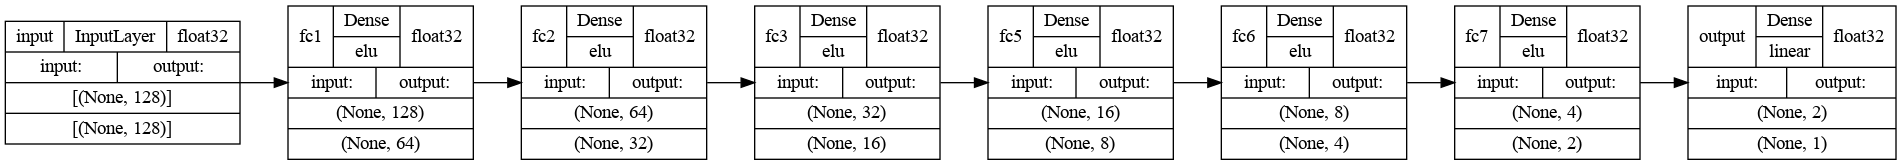

In [96]:
plot_model(fc_m,
           rankdir="LR",
           show_shapes=True,
           show_dtype=True,
           show_layer_activations=True,
           to_file="fully_connected.png")

In [97]:
fc_m.compile(optimizer="adam",
             loss="mse",
             metrics=[error])

In [98]:
# train the model
history = fc_m.fit(X,
                   y,
                   epochs=20,
                   batch_size=128,
                   verbose=1,
                   shuffle=False)

Epoch 1/20
256/256 [==============================] - 1s 2ms/step - loss: 1.4737 - error: -0.0044
Epoch 2/20
256/256 [==============================] - 0s 2ms/step - loss: 1.2253 - error: 7.5767e-04
Epoch 3/20
256/256 [==============================] - 0s 2ms/step - loss: 1.1836 - error: 0.0020
Epoch 4/20
256/256 [==============================] - 0s 2ms/step - loss: 1.1530 - error: 6.1121e-04
Epoch 5/20
256/256 [==============================] - 0s 2ms/step - loss: 1.1406 - error: 8.6917e-04
Epoch 6/20
256/256 [==============================] - 0s 2ms/step - loss: 1.1377 - error: 0.0018
Epoch 7/20
256/256 [==============================] - 0s 1ms/step - loss: 1.1267 - error: 0.0017
Epoch 8/20
256/256 [==============================] - 0s 1ms/step - loss: 1.1257 - error: 0.0018
Epoch 9/20
256/256 [==============================] - 0s 1ms/step - loss: 1.1276 - error: 0.0016
Epoch 10/20
256/256 [==============================] - 0s 2ms/step - loss: 1.1215 - error: 0.0014
Epoch 11/20
256/

### LSTM net

In [88]:
input_  = Input(shape=(MAX_ARRIVALS,), name="input")
reshape = Reshape((MAX_ARRIVALS, 1), name="reshape")
lstm    = LSTM(16, name="lstm")
fc1     = Dense(8, name="fc1", activation="elu")
fc2     = Dense(4, name="fc2", activation="elu")
fc3     = Dense(2, name="fc3", activation="elu")
output_ = Dense(1, name="output")
lstm_m  = keras.Sequential([input_, reshape, lstm, fc1, fc2, fc3, output_], name='LSTM')

In [89]:
lstm_m.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 fc1 (Dense)                 (None, 8)                 136       
                                                                 
 fc2 (Dense)                 (None, 4)                 36        
                                                                 
 fc3 (Dense)                 (None, 2)                 10        
                                                                 
 output (Dense)              (None, 1)                 3         
                                                                 
Total params: 1,337
Trainable params: 1,337
Non-trainable para

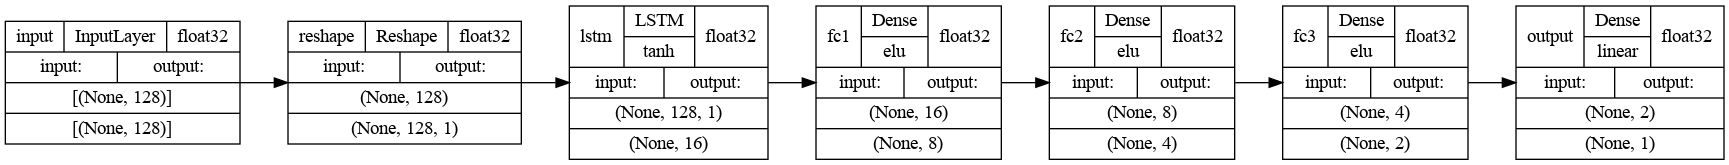

In [108]:
plot_model(lstm_m,
           rankdir="LR",
           show_shapes=True,
           show_dtype=True,
           show_layer_activations=True,
           to_file="lstm.png")

In [91]:
lstm_m.compile(optimizer="adam",
               loss="mse",
               metrics=[error])

In [92]:
# train the model
history = lstm_m.fit(X,
                     y,
                     epochs=20,
                     batch_size=128,
                     verbose=1,
                     shuffle=False)

Epoch 1/20
256/256 [==============================] - 9s 31ms/step - loss: 7.1478 - error: 0.7612
Epoch 2/20
256/256 [==============================] - 8s 30ms/step - loss: 1.8132 - error: 0.0082
Epoch 3/20
256/256 [==============================] - 7s 29ms/step - loss: 1.6896 - error: 0.0023
Epoch 4/20
256/256 [==============================] - 7s 29ms/step - loss: 1.6427 - error: 0.0017
Epoch 5/20
256/256 [==============================] - 7s 29ms/step - loss: 1.5971 - error: 0.0019
Epoch 6/20
256/256 [==============================] - 8s 30ms/step - loss: 1.5209 - error: 0.0045
Epoch 7/20
256/256 [==============================] - 8s 31ms/step - loss: 1.3236 - error: -0.0028
Epoch 8/20
256/256 [==============================] - 8s 30ms/step - loss: 1.2379 - error: 0.0014
Epoch 9/20
256/256 [==============================] - 8s 31ms/step - loss: 1.1969 - error: 0.0021
Epoch 10/20
256/256 [==============================] - 8s 30ms/step - loss: 1.1827 - error: 9.8042e-04
Epoch 11/20
25

### GRU net

In [113]:
input_  = Input(shape=(MAX_ARRIVALS,), name="input")
reshape = Reshape((MAX_ARRIVALS, 1), name="reshape")
gru     = GRU(16, name="gru")
fc1     = Dense(8, name="fc1", activation="elu")
fc2     = Dense(4, name="fc2", activation="elu")
fc3     = Dense(2, name="fc3", activation="elu")
output_ = Dense(1, name="output")
gru_m  = keras.Sequential([input_, reshape, gru, fc1, fc2, fc3, output_], name='GRU')

In [114]:
gru_m.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 gru (GRU)                   (None, 16)                912       
                                                                 
 fc1 (Dense)                 (None, 8)                 136       
                                                                 
 fc2 (Dense)                 (None, 4)                 36        
                                                                 
 fc3 (Dense)                 (None, 2)                 10        
                                                                 
 output (Dense)              (None, 1)                 3         
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable param

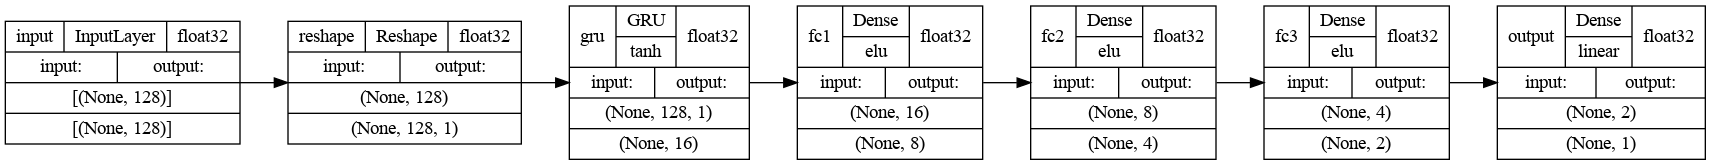

In [115]:
plot_model(gru_m,
           rankdir="LR",
           show_shapes=True,
           show_dtype=True,
           show_layer_activations=True,
           to_file="gru.png")

In [116]:
gru_m.compile(optimizer="adam",
              loss="mse",
              metrics=[error])

In [117]:
# train the model
history = gru_m.fit(X,
                    y,
                    epochs=20,
                    batch_size=128,
                    verbose=1,
                    shuffle=False)

Epoch 1/20
256/256 [==============================] - 9s 29ms/step - loss: 9.1165 - error: 1.3494
Epoch 2/20
256/256 [==============================] - 7s 29ms/step - loss: 7.2930 - error: 0.5685
Epoch 3/20
256/256 [==============================] - 7s 29ms/step - loss: 7.0183 - error: 0.2431
Epoch 4/20
256/256 [==============================] - 8s 30ms/step - loss: 6.9621 - error: 0.0860
Epoch 5/20
256/256 [==============================] - 7s 29ms/step - loss: 6.1785 - error: 0.3504
Epoch 6/20
256/256 [==============================] - 8s 29ms/step - loss: 3.4572 - error: 0.6624
Epoch 7/20
256/256 [==============================] - 7s 29ms/step - loss: 2.6260 - error: 0.4563
Epoch 8/20
256/256 [==============================] - 7s 29ms/step - loss: 2.1703 - error: 0.3393
Epoch 9/20
256/256 [==============================] - 7s 28ms/step - loss: 1.8821 - error: 0.2576
Epoch 10/20
256/256 [==============================] - 7s 28ms/step - loss: 1.6889 - error: 0.2011
Epoch 11/20
256/256

## Statistical analysis

In [48]:
def repeat_ests(model, a, b, mu, beg, end, n_repeats, seed):
    """
    Repeats estimations of tau
    """
    rng = np.random.default_rng(seed) # for reproducibility
    
    arrivals_l = []
    taus_l     = []
    est_taus_l = []
    
    for repeat in tqdm(range(n_repeats)):
        arrivals, tau = trajectory(a, b, mu, beg, end, rng)
        arrivals_l.append(arrivals)
        taus_l.append(tau)
        tau_est = model(arrivals.reshape(1, -1)).numpy()[0][0]
        est_taus_l.append(tau_est)
        
    return taus_l, est_taus_l

In [18]:
def stat_summary(taus_l, est_taus_l):
    """
    Prints a summary of the estimator and a bar plot of the errors
    """    
    taus_arr = np.array(taus_l)
    est_taus_arr = np.array(est_taus_l)
    
    error = taus_arr - est_taus_arr
    
    print(f"bias: {np.mean(error):.2f}")
    print(f"sigma: {np.std(error):.2f}")
    print(f"mu={mu}\na={a}\nb={b}")
    
    fig = plt.figure(figsize=(10, 3))
    plt.hist(error, bins=50)
    plt.title(fr"$\tau - \hat{{\tau}}$")
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 340.33it/s]


bias: -0.03
sigma: 1.03
mu=0.2
a=5
b=10


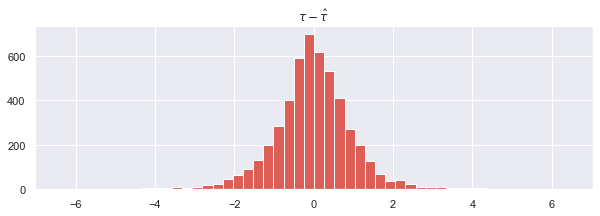

In [99]:
taus_l, est_taus_l = repeat_ests(fc_m, a, b, mu, beg, end, n_repeats=5000, seed=42)
stat_summary(taus_l, est_taus_l)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.92it/s]


bias: 0.05
sigma: 1.07
mu=0.2
a=5
b=10


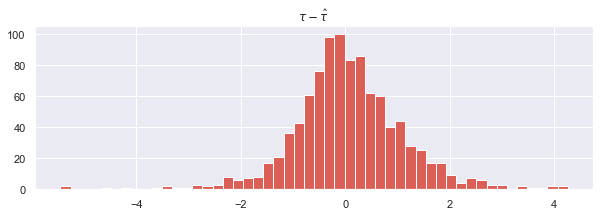

In [101]:
taus_l, est_taus_l = repeat_ests(lstm_m, a, b, mu, beg, end, n_repeats=1000, seed=42)
stat_summary(taus_l, est_taus_l)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


bias: 0.09
sigma: 1.07
mu=0.2
a=5
b=10


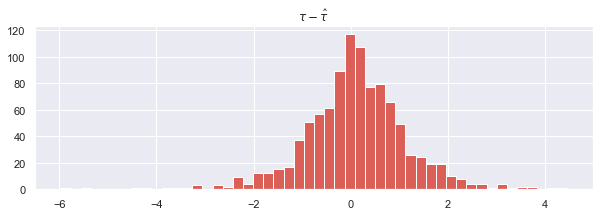

In [118]:
taus_l, est_taus_l = repeat_ests(gru_m, a, b, mu, beg, end, n_repeats=1000, seed=42)
stat_summary(taus_l, est_taus_l)